# **DuaSHAP: Dual-Model SHAP Feature Prioritization Framework For Drug-Induced Autoimmunity (DIA) and Drug-Likeness Analysis**

**Student:** Nelson Jonathan (202508352)<br>
**Course:** Introduction to Machine Learning (Fall 2025)<br>
**Institution:** Woosong University

---

### Project Goal
Identify molecular features that simultaneously:
- **Decrease** Drug-Induced Autoimmunity (DIA) risk
- **Increase** Drug-likeness (optimal molecular properties)

These "Sweet Spot" features guide rational, low-risk drug design.

---
**Reference Research Paper**<br>
Lina Huang, Peineng Liu, Xiaojie Huang,
InterDIA: Interpretable prediction of drug-induced autoimmunity through ensemble machine learning approaches,
Toxicology,
Volume 511,
2025,
154064,
ISSN 0300-483X,
https://doi.org/10.1016/j.tox.2025.154064.
(https://www.sciencedirect.com/science/article/pii/S0300483X25000204)

<br>**Dataset**<br>
https://github.com/Huangxiaojie2024/InterDIA/tree/main/DataSet by Lina Huang, Peineng Liu, Xiaojie Huang

## 1. Setup and Installation

In [ ]:
# Install required packages (if needed)
!pip install shap xgboost scikit-learn pandas numpy matplotlib seaborn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, classification_report,
                             confusion_matrix, r2_score, mean_squared_error)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor

import shap

## 2. Load Data
Dataset used: https://github.com/Huangxiaojie2024/InterDIA/tree/main/DataSet by Lina Huang, Peineng Liu, Xiaojie Huang

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
train_path = '/content/drive/MyDrive/intro_ml/DIA_trainingset_RDKit_descriptors.csv'
test_path = '/content/drive/MyDrive/intro_ml/DIA_testset_RDKit_descriptors.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

print(f"Training set: {df_train.shape[0]} compounds, {df_train.shape[1]} columns")
print(f"Test set: {df_test.shape[0]} compounds, {df_test.shape[1]} columns")
print(f"\nLabel distribution (Training):")
print(df_train['Label'].value_counts())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training set: 477 compounds, 198 columns
Test set: 120 compounds, 198 columns

Label distribution (Training):
Label
0    359
1    118
Name: count, dtype: int64


In [ ]:
# preview
df_train.head()

,Label,SMILES,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,COC(=O)N(C)c1c(N)nc(nc1N)c2nn(Cc3ccccc3F)c4ncc...,1.821,1266.407,22.121,16.781,16.781,14.901,9.203,9.203,...,0,0,0,0,0,0,0,0,0,0
1,0,C[C@H](N(O)C(=O)N)c1cc2ccccc2s1,2.363,490.434,11.707,8.752,9.569,7.592,4.854,5.670,...,0,0,0,0,0,0,0,1,0,1
2,0,C[N+](C)(C)CC(=O)[O-],3.551,93.092,6.784,5.471,5.471,3.417,2.420,2.420,...,0,0,0,0,0,0,0,0,0,0
3,1,CC(C)n1c(\C=C\[C@H](O)C[C@H](O)CC(=O)O)c(c2ccc...,2.076,1053.003,21.836,16.995,16.995,14.274,9.926,9.926,...,0,0,0,0,0,0,0,0,0,0
4,1,C\C(=C(\C#N)/C(=O)Nc1ccc(cc1)C(F)(F)F)\O,2.888,549.823,14.629,9.746,9.746,8.752,5.040,5.040,...,0,0,0,0,0,0,0,0,0,0


## 3. Data Preprocessing

In [ ]:
# drop 'Label' (DIA target), 'SMILES' (molecular structure string)

non_feature_cols = ['Label', 'SMILES']
feature_cols = [col for col in df_train.columns if col not in non_feature_cols]

print(f"Number of features: {len(feature_cols)}")
print(f"\nFirst 10 features: {feature_cols[:10]}")
print(f"\n'MolLogP' in features: {'MolLogP' in feature_cols}")

Number of features: 196

First 10 features: ['BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v']

'MolLogP' in features: True


In [ ]:
# SET 1: DIA (Drug-induced Autoimmunity)
X_train = df_train[feature_cols].copy()
X_test = df_test[feature_cols].copy()

y_train_dia = df_train['Label'].copy()
y_test_dia = df_test['Label'].copy()

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\nDIA label distribution (train): \n{y_train_dia.value_counts()}")

X_train shape: (477, 196)
X_test shape: (120, 196)

DIA label distribution (train): 
Label
0    359
1    118
Name: count, dtype: int64


###For the cell below
According to Lipinski's Rule of 5, **optimal mollogp range should be [1, 3]**. <br>
Anything outside means that the druglikeness (how well it can be absorbed) is weaker.

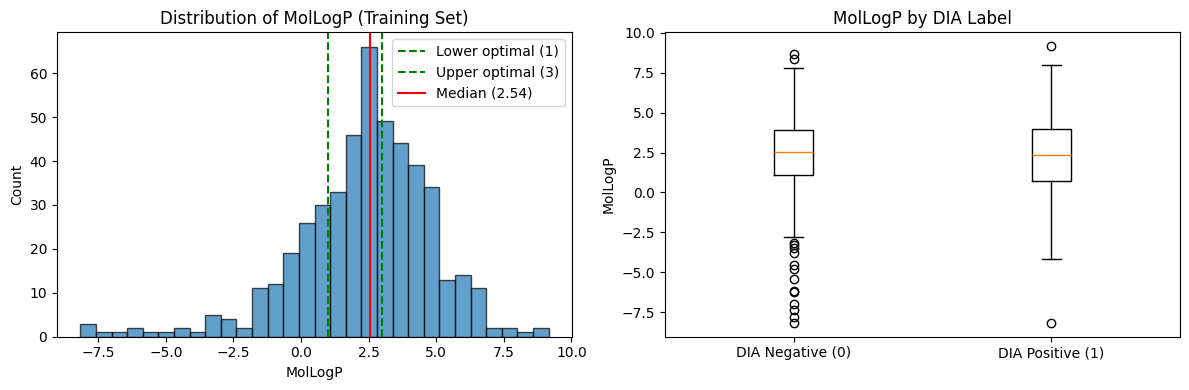


MolLogP statistics:
count    477.000000
mean       2.336004
std        2.527180
min       -8.161000
25%        1.049000
50%        2.535000
75%        3.960000
max        9.158000
Name: MolLogP, dtype: float64


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# distribution of MolLogP
axes[0].hist(X_train['MolLogP'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(x=1, color='green', linestyle='--', label='Lower optimal (1)')
axes[0].axvline(x=3, color='green', linestyle='--', label='Upper optimal (3)')
axes[0].axvline(x=X_train['MolLogP'].median(), color='red', linestyle='-', label=f'Median ({X_train["MolLogP"].median():.2f})')
axes[0].set_xlabel('MolLogP')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of MolLogP (Training Set)')
axes[0].legend()

# MolLogP vs DIA Label, check
axes[1].boxplot([X_train.loc[y_train_dia == 0, 'MolLogP'],
                 X_train.loc[y_train_dia == 1, 'MolLogP']],
                labels=['DIA Negative (0)', 'DIA Positive (1)'])
axes[1].set_ylabel('MolLogP')
axes[1].set_title('MolLogP by DIA Label')

plt.tight_layout()
plt.show()

print(f"\nMolLogP statistics:")
print(X_train['MolLogP'].describe())

###For the cell above

Interpreting the results:
1. Median of samples' MolLogP is within optimal range.
2. MolLogP has a weak effect on toxicity, making it a valid second target.


In [ ]:
def create_druglikeness_target(mollogp, lower=1, upper=3):
    """Return 1 if MolLogP in optimal range, 0 otherwise"""
    return ((mollogp >= lower) & (mollogp <= upper)).astype(int)

y_train_druglike = create_druglikeness_target(X_train['MolLogP'])
y_test_druglike = create_druglikeness_target(X_test['MolLogP'])

print("Drug-likeness target distribution (training):")
print(y_train_druglike.value_counts())
print(f"\n% in optimal range: {y_train_druglike.mean()*100:.1f}%")

Drug-likeness target distribution (training):
MolLogP
0    316
1    161
Name: count, dtype: int64

% in optimal range: 33.8%


In [ ]:
# remove MolLogP target
feature_cols_no_logp = [col for col in feature_cols if col != 'MolLogP']

X_train_m2 = X_train[feature_cols_no_logp].copy()
X_test_m2 = X_test[feature_cols_no_logp].copy()

print(f"Features for Model 1 (DIA): {len(feature_cols)} features (including MolLogP)")
print(f"Features for Model 2 (Drug-likeness): {len(feature_cols_no_logp)} features (excluding MolLogP)")

Features for Model 1 (DIA): 196 features (including MolLogP)
Features for Model 2 (Drug-likeness): 195 features (excluding MolLogP)


In [ ]:
# dataset should already be clean, but just in case.
print("Missing values in training set:")
missing = X_train.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("No missing values!")

# check const features and remove, if any.
constant_features = X_train.columns[X_train.std() == 0].tolist()
print(f"\nConstant features (will be removed): {constant_features}") # just for reference for manual checks

if constant_features:
    feature_cols = [col for col in feature_cols if col not in constant_features]
    feature_cols_no_logp = [col for col in feature_cols_no_logp if col not in constant_features]
    X_train = X_train[feature_cols]
    X_test = X_test[feature_cols]
    X_train_m2 = X_train_m2[[c for c in feature_cols_no_logp if c in X_train_m2.columns]]
    X_test_m2 = X_test_m2[[c for c in feature_cols_no_logp if c in X_test_m2.columns]]
    print(f"Removed {len(constant_features)} constant features")

Missing values in training set:
No missing values!

Constant features (will be removed): ['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'VSA_EState1', 'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState6', 'VSA_EState7', 'fr_azide', 'fr_barbitur', 'fr_diazo', 'fr_isocyan', 'fr_isothiocyan', 'fr_prisulfonamd', 'fr_thiocyan']
Removed 17 constant features


## 4. Model 1: DIA Toxicity Classifier with XGBoost

Note: [Cell shows class imbalance for DIA labels](https://colab.research.google.com/drive/1L9ddOMYdJmknnOWVtnvPaBM3qo_axDBg?authuser=4#scrollTo=-1S0sPeie3C6&line=4&uniqifier=1). Will be handled by increasing punishment for the smaller label count.

In [ ]:
# increase punishment for smaller class label counts
neg_count = (y_train_dia == 0).sum()
pos_count = (y_train_dia == 1).sum()
scale_pos_weight = neg_count / pos_count

print(f"Class distribution: Negative={neg_count}, Positive={pos_count}")
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

# init xgboost model
model_dia = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# cross validate with jumbled train and test that have the same class ratio, just for self reference
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_scores = cross_val_score(model_dia, X_train, y_train_dia, cv=cv, scoring='roc_auc')

print(f"\n{n_splits}-Fold CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

Class distribution: Negative=359, Positive=118
scale_pos_weight: 3.04

5-Fold CV AUC: 0.8442 (+/- 0.0812)


In [ ]:
# train
model_dia.fit(X_train, y_train_dia)

# eval (just as baseline for reference, will optimize later)
y_pred_dia = model_dia.predict(X_test)
y_prob_dia = model_dia.predict_proba(X_test)[:, 1]

print("=" * 50)
print("MODEL 1: DIA TOXICITY CLASSIFIER - TEST SET RESULTS")
print("=" * 50)
print(f"\nAUC: {roc_auc_score(y_test_dia, y_prob_dia):.4f}")
print(f"Accuracy: {accuracy_score(y_test_dia, y_pred_dia):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test_dia, y_pred_dia, target_names=['DIA Negative', 'DIA Positive']))

MODEL 1: DIA TOXICITY CLASSIFIER - TEST SET RESULTS

AUC: 0.8733
Accuracy: 0.8000

Classification Report:
              precision    recall  f1-score   support

DIA Negative       0.82      0.94      0.88        90
DIA Positive       0.69      0.37      0.48        30

    accuracy                           0.80       120
   macro avg       0.75      0.66      0.68       120
weighted avg       0.78      0.80      0.78       120



Optimize hyperparameters with GridSearchCV

In [ ]:
print("="*60)
print("HYPERPARAMETER OPTIMIZATION - MODEL 1 (DIA)")
print("="*60)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]
}

# Grid search with cross-validation
xgb_base = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

grid_search = GridSearchCV(
    xgb_base,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train_dia)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV AUC: {grid_search.best_score_:.4f}")

# use best model
model_dia_optimized = grid_search.best_estimator_

y_pred_optimized = model_dia_optimized.predict(X_test)
y_prob_optimized = model_dia_optimized.predict_proba(X_test)[:, 1]
auc_optimized = roc_auc_score(y_test_dia, y_prob_optimized)

# compare against prev
print(f"\nPerformance Comparison:")
print(f"  Default parameters AUC:   {roc_auc_score(y_test_dia, y_prob_dia):.4f}")
print(f"  Optimized parameters AUC: {auc_optimized:.4f}")
print(f"  Improvement: {(auc_optimized - roc_auc_score(y_test_dia, y_prob_dia))*100:.2f}%")

print(f"\nClassification Report (Optimized Model):")
print(classification_report(y_test_dia, y_pred_optimized, target_names=['DIA Negative', 'DIA Positive']))

HYPERPARAMETER OPTIMIZATION - MODEL 1 (DIA)
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200}
Best CV AUC: 0.8568

Performance Comparison:
  Default parameters AUC:   0.8733
  Optimized parameters AUC: 0.8763
  Improvement: 0.30%

Classification Report (Optimized Model):
              precision    recall  f1-score   support

DIA Negative       0.81      0.94      0.87        90
DIA Positive       0.67      0.33      0.44        30

    accuracy                           0.79       120
   macro avg       0.74      0.64      0.66       120
weighted avg       0.77      0.79      0.76       120



Find optimal threshold using Youden's J, since it's not predicting DIA positive properly (0.33 recall)

Note: Threshold optimization is irrelevant to SHAP analysis. SHAP explains
probabilities, not classifications. This is only relevant for model deployment.

In [ ]:
# find optimal threshold
fpr, tpr, thresholds = roc_curve(y_test_dia, y_prob_dia)
j_scores = tpr - fpr
best_idx = j_scores.argmax()
optimal_threshold = thresholds[best_idx]

print("="*50)
print("THRESHOLD OPTIMIZATION (Youden's J)")
print("="*50)

print(f"\nOptimal threshold: {optimal_threshold:.3f}")

# default threshold (0.5) - what was used in cell previous
y_pred_default = (y_prob_dia >= 0.5).astype(int)

# optimal threshold
y_pred_optimal = (y_prob_dia >= optimal_threshold).astype(int)

print(f"\n{'Metric':<20} {'Default (0.5)':<15} {'Optimal':<15}")
print("-"*50)
print(f"{'Accuracy':<20} {accuracy_score(y_test_dia, y_pred_default):<15.2%} {accuracy_score(y_test_dia, y_pred_optimal):<15.2%}")
print(f"{'Toxic Recall':<20} {recall_score(y_test_dia, y_pred_default):<15.2%} {recall_score(y_test_dia, y_pred_optimal):<15.2%}")
print(f"{'Toxic Precision':<20} {precision_score(y_test_dia, y_pred_default):<15.2%} {precision_score(y_test_dia, y_pred_optimal):<15.2%}")

print("\n" + "="*50)
print("CLASSIFICATION REPORT (Optimal Threshold)")
print("="*50)
print(classification_report(y_test_dia, y_pred_optimal, target_names=['DIA Negative', 'DIA Positive']))

THRESHOLD OPTIMIZATION (Youden's J)

Optimal threshold: 0.202

Metric               Default (0.5)   Optimal        
--------------------------------------------------
Accuracy             80.00%          81.67%         
Toxic Recall         36.67%          83.33%         
Toxic Precision      68.75%          59.52%         

CLASSIFICATION REPORT (Optimal Threshold)
              precision    recall  f1-score   support

DIA Negative       0.94      0.81      0.87        90
DIA Positive       0.60      0.83      0.69        30

    accuracy                           0.82       120
   macro avg       0.77      0.82      0.78       120
weighted avg       0.85      0.82      0.83       120



## 5. Model 2: Drug-Likeness Classifier with XGBoost

Note: [Cell shows class imbalance for MolLogP labels](https://colab.research.google.com/drive/1L9ddOMYdJmknnOWVtnvPaBM3qo_axDBg?authuser=4#scrollTo=GM2fKctEe3C7&line=5&uniqifier=1). Will be handled by increasing punishment for the smaller label count.

In [ ]:
# increase punishment for smaller class label counts
neg_count_dl = (y_train_druglike == 0).sum()
pos_count_dl = (y_train_druglike == 1).sum()
scale_pos_weight_dl = neg_count_dl / pos_count_dl if pos_count_dl > 0 else 1

print(f"Class distribution: Not drug-like={neg_count_dl}, Drug-like={pos_count_dl}")
print(f"scale_pos_weight: {scale_pos_weight_dl:.2f}")

# init xgboost model, same hyperparams as DIA model
model_druglike = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight_dl,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# cross validate with jumbled train and test that have the same class ratio, just for self reference
cv_scores_dl = cross_val_score(model_druglike, X_train_m2, y_train_druglike, cv=cv, scoring='roc_auc')

print(f"\n5-Fold CV AUC: {cv_scores_dl.mean():.4f} (+/- {cv_scores_dl.std()*2:.4f})")

Class distribution: Not drug-like=316, Drug-like=161
scale_pos_weight: 1.96

5-Fold CV AUC: 0.8661 (+/- 0.0710)


In [ ]:
# train
model_druglike.fit(X_train_m2, y_train_druglike)

# eval (just as baseline for reference, will optimize later)
y_pred_druglike = model_druglike.predict(X_test_m2)
y_prob_druglike = model_druglike.predict_proba(X_test_m2)[:, 1]

print("=" * 50)
print("MODEL 2: DRUG-LIKENESS CLASSIFIER - TEST SET RESULTS")
print("=" * 50)
print(f"\nAUC: {roc_auc_score(y_test_druglike, y_prob_druglike):.4f}")
print(f"Accuracy: {accuracy_score(y_test_druglike, y_pred_druglike):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test_druglike, y_pred_druglike, target_names=['Not Drug-like', 'Drug-like']))

MODEL 2: DRUG-LIKENESS CLASSIFIER - TEST SET RESULTS

AUC: 0.9224
Accuracy: 0.8583

Classification Report:
               precision    recall  f1-score   support

Not Drug-like       0.91      0.90      0.90        86
    Drug-like       0.74      0.76      0.75        34

     accuracy                           0.86       120
    macro avg       0.82      0.83      0.83       120
 weighted avg       0.86      0.86      0.86       120



Optimize hyperparameters with GridSearchCV

In [ ]:
print("="*60)
print("HYPERPARAMETER OPTIMIZATION - Model 2 (DL)")
print("="*60)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]
}

# Grid search with cross-validation
xgb_base_dl = XGBClassifier(
    scale_pos_weight=scale_pos_weight_dl,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

grid_search_dl = GridSearchCV(
    xgb_base_dl,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search_dl.fit(X_train_m2, y_train_druglike)

print(f"\nBest parameters: {grid_search_dl.best_params_}")
print(f"Best CV AUC: {grid_search_dl.best_score_:.4f}")

# use best model
model_druglike_optimized = grid_search_dl.best_estimator_

y_pred_dl_optimized = model_druglike_optimized.predict(X_test_m2)
y_prob_dl_optimized = model_druglike_optimized.predict_proba(X_test_m2)[:, 1]
auc_dl_optimized = roc_auc_score(y_test_druglike, y_prob_dl_optimized)

# compare against prev
print(f"\nPerformance Comparison:")
print(f"  Default parameters AUC:   {roc_auc_score(y_test_druglike, y_prob_druglike):.4f}")
print(f"  Optimized parameters AUC: {auc_dl_optimized:.4f}")
print(f"  Improvement: {(auc_dl_optimized - roc_auc_score(y_test_druglike, y_prob_druglike))*100:.2f}%")

print(f"\nClassification Report (Optimized Model):")
print(classification_report(y_test_druglike, y_pred_dl_optimized, target_names=['Not Drug-like', 'Drug-like']))

HYPERPARAMETER OPTIMIZATION - Model 2 (DL)
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200}
Best CV AUC: 0.8521

Performance Comparison:
  Default parameters AUC:   0.9224
  Optimized parameters AUC: 0.9179
  Improvement: -0.44%

Classification Report (Optimized Model):
               precision    recall  f1-score   support

Not Drug-like       0.90      0.90      0.90        86
    Drug-like       0.74      0.74      0.74        34

     accuracy                           0.85       120
    macro avg       0.82      0.82      0.82       120
 weighted avg       0.85      0.85      0.85       120



Find optimal threshold using Youden's J, for consistency.

Note: Threshold optimization is irrelevant to SHAP analysis. SHAP explains
probabilities, not classifications. This is only relevant for model deployment.

In [ ]:
# find optimal threshold
fpr_dl, tpr_dl, thresholds_dl = roc_curve(y_test_druglike, y_prob_dl_optimized)
j_scores_dl = tpr_dl - fpr_dl
best_idx_dl = j_scores_dl.argmax()
optimal_threshold_dl = thresholds_dl[best_idx_dl]

print("="*50)
print("THRESHOLD OPTIMIZATION - Model 2 (Youden's J)")
print("="*50)

print(f"\nOptimal threshold: {optimal_threshold_dl:.3f}")

# default threshold (0.5) - what was used in cell previous
y_pred_dl_default = (y_prob_dl_optimized >= 0.5).astype(int)

# optimal threshold
y_pred_dl_optimal = (y_prob_dl_optimized >= optimal_threshold_dl).astype(int)

print(f"\n{'Metric':<20} {'Default (0.5)':<15} {'Optimal':<15}")
print("-"*50)
print(f"{'Accuracy':<20} {accuracy_score(y_test_druglike, y_pred_dl_default):<15.2%} {accuracy_score(y_test_druglike, y_pred_dl_optimal):<15.2%}")
print(f"{'Drug-like Recall':<20} {recall_score(y_test_druglike, y_pred_dl_default):<15.2%} {recall_score(y_test_druglike, y_pred_dl_optimal):<15.2%}")
print(f"{'Drug-like Precision':<20} {precision_score(y_test_druglike, y_pred_dl_default):<15.2%} {precision_score(y_test_druglike, y_pred_dl_optimal):<15.2%}")

print("\n" + "="*50)
print("CLASSIFICATION REPORT (Optimal Threshold)")
print("="*50)
print(classification_report(y_test_druglike, y_pred_dl_optimal, target_names=['Not Drug-like', 'Drug-like']))

THRESHOLD OPTIMIZATION - Model 2 (Youden's J)

Optimal threshold: 0.148

Metric               Default (0.5)   Optimal        
--------------------------------------------------
Accuracy             85.00%          80.00%         
Drug-like Recall     73.53%          100.00%        
Drug-like Precision  73.53%          58.62%         

CLASSIFICATION REPORT (Optimal Threshold)
               precision    recall  f1-score   support

Not Drug-like       1.00      0.72      0.84        86
    Drug-like       0.59      1.00      0.74        34

     accuracy                           0.80       120
    macro avg       0.79      0.86      0.79       120
 weighted avg       0.88      0.80      0.81       120



For cell above

Since accuracy actually became worse, actual deployment should stick to default of 0.5 threshold. There's no need to increase the drug-like recall.

## 6. SHAP Analysis

In [ ]:
print("="*60)
print("SHAP ANALYSIS FOR MODEL 1 (DIA))")
print("="*60)

# give exact shap vals
explainer_dia = shap.TreeExplainer(model_dia_optimized)
shap_values_dia = explainer_dia.shap_values(X_train)

print(f"SHAP values shape: {shap_values_dia.shape}")

SHAP ANALYSIS FOR MODEL 1 (DIA))
SHAP values shape: (477, 179)


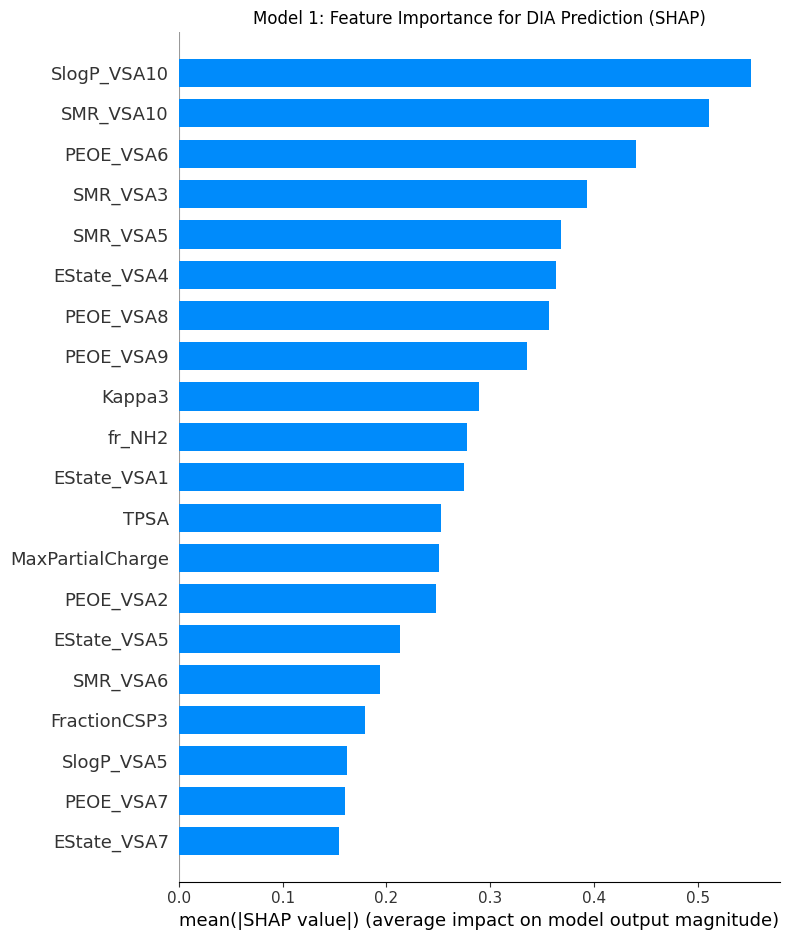

In [ ]:
# SHAP summary plot for DIA model.
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_dia, X_train, plot_type="bar", max_display=20, show=False) # set max_display=200 to show all
plt.title("Model 1: Feature Importance for DIA Prediction (SHAP)")
plt.tight_layout()
plt.show()

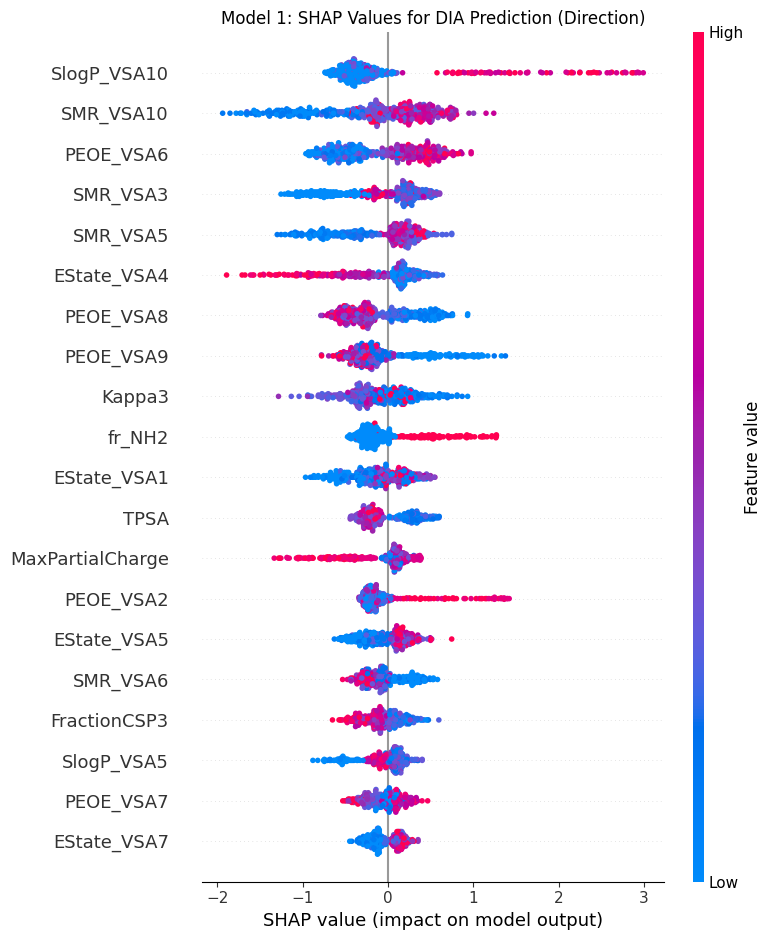

In [ ]:
# SHAP beeswarm plot (shows direction)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_dia, X_train, max_display=20, show=False) # set max_display=200 to show all
plt.title("Model 1: SHAP Values for DIA Prediction (Direction)")
plt.tight_layout()
plt.show()

In [ ]:
print("="*60)
print("SHAP ANALYSIS FOR MODEL 2 (Drug-Likeness)")
print("="*60)

print("Calculating SHAP values for Model 2 (Drug-likeness)...")

explainer_druglike = shap.TreeExplainer(model_druglike_optimized)
shap_values_druglike = explainer_druglike.shap_values(X_train_m2)

print(f"SHAP values shape: {shap_values_druglike.shape}")

SHAP ANALYSIS FOR MODEL 2 (Drug-Likeness)
Calculating SHAP values for Model 2 (Drug-likeness)...
SHAP values shape: (477, 178)


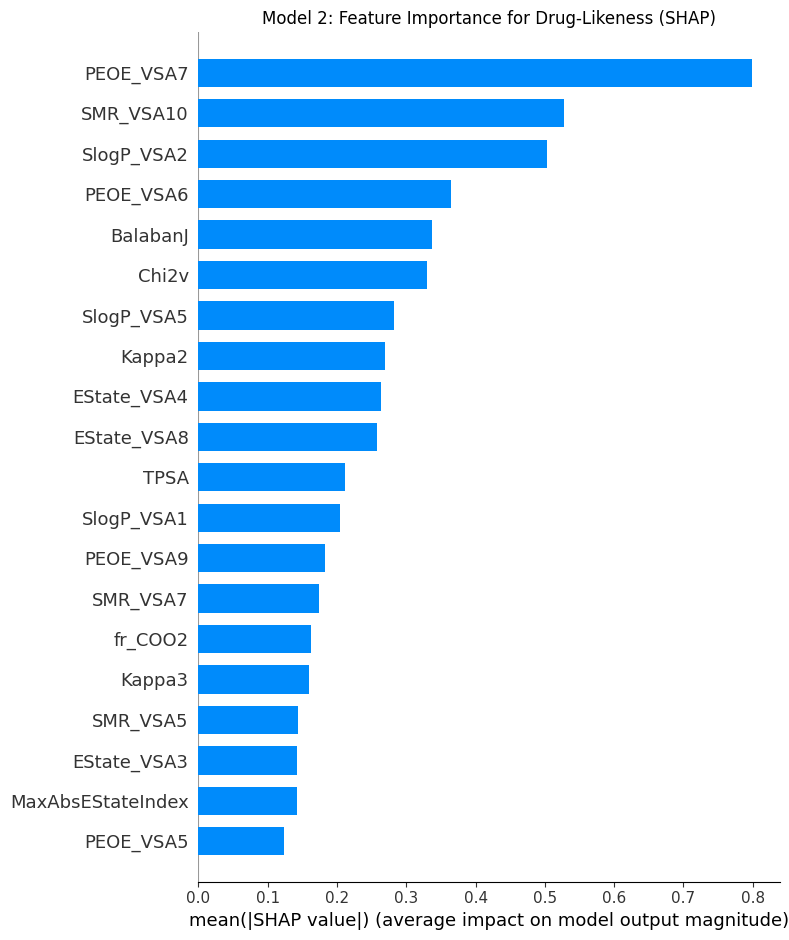

In [ ]:
# SHAP summary plot for DL model
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_druglike, X_train_m2, plot_type="bar", max_display=20, show=False) # set max_display=200 to show all
plt.title("Model 2: Feature Importance for Drug-Likeness (SHAP)")
plt.tight_layout()
plt.show()

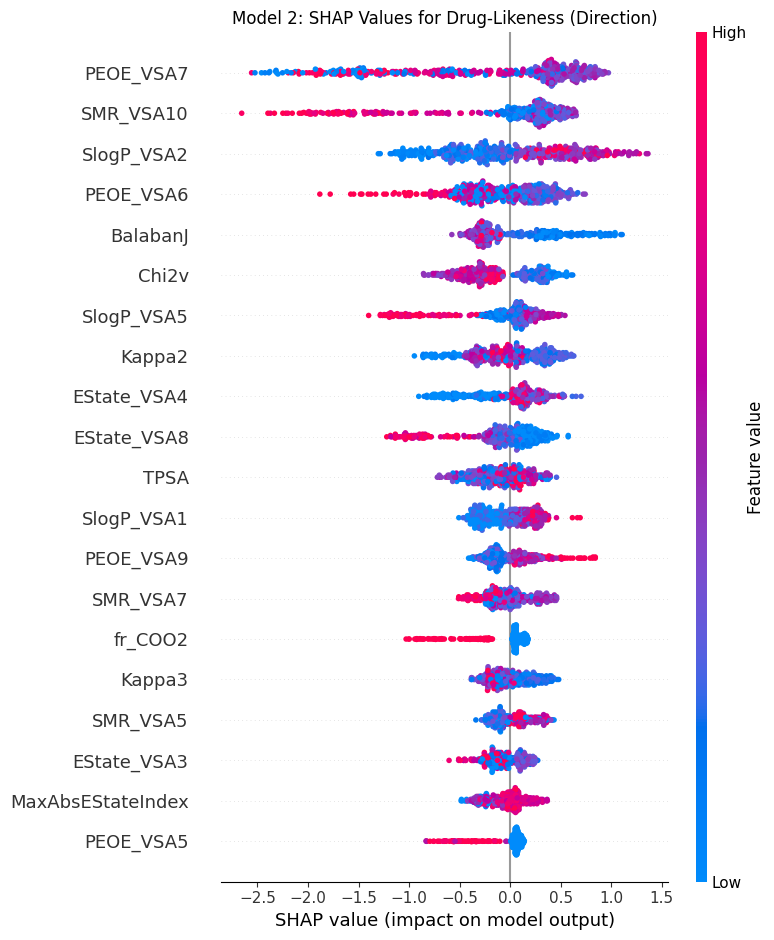

In [ ]:
# SHAP beeswarm plot for DL
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_druglike, X_train_m2, max_display=20, show=False) # set max_display=200 to show all
plt.title("Model 2: SHAP Values for Drug-Likeness (Direction)")
plt.tight_layout()
plt.show()

## 7. Build Antagonistic Feature Matrix

In [ ]:
print("="*60)
print("CALCULATE MEAN DIRECTIONAL SHAP VALUES")
print("="*60)

# Model 1 (DIA): +ve SHAP = +ve DIA
# Model 2 (DL): +ve SHAP = +ve DL

# calculate mean SHAP per feature
mean_shap_dia = pd.Series(
    shap_values_dia.mean(axis=0),
    index=X_train.columns,
    name='SHAP_DIA'
)

mean_shap_druglike = pd.Series(
    shap_values_druglike.mean(axis=0),
    index=X_train_m2.columns,
    name='SHAP_DrugLike'
)

# calculate mean absolute SHAP for importance ranking
mean_abs_shap_dia = pd.Series(
    np.abs(shap_values_dia).mean(axis=0),
    index=X_train.columns,
    name='Abs_SHAP_DIA'
)

mean_abs_shap_druglike = pd.Series(
    np.abs(shap_values_druglike).mean(axis=0),
    index=X_train_m2.columns,
    name='Abs_SHAP_DrugLike'
)

print("Mean SHAP values calculated!")
print(f"\nTop 5 features increasing DIA risk:")
print(mean_shap_dia.sort_values(ascending=False).head())
print(f"\nTop 5 features increasing Drug-likeness:")
print(mean_shap_druglike.sort_values(ascending=False).head())

CALCULATE MEAN DIRECTIONAL SHAP VALUES
Mean SHAP values calculated!

Top 5 features increasing DIA risk:
HeavyAtomMolWt              0.011855
Chi0v                       0.006033
NumAliphaticHeterocycles    0.002363
NumHAcceptors               0.001789
fr_C_O                      0.001633
Name: SHAP_DIA, dtype: float32

Top 5 features increasing Drug-likeness:
BalabanJ      0.036226
SMR_VSA5      0.012732
MolMR         0.011453
SlogP_VSA2    0.005052
Kappa3        0.004802
Name: SHAP_DrugLike, dtype: float32


In [ ]:
print("="*60)
print("NORMALIZE SHAP VALUES TO [-1, +1]")
print("="*60)

# to compare shap value of both models

def normalize_shap(shap_series):
    """Normalize SHAP values to [-1, +1] range"""
    max_abs = np.abs(shap_series).max()
    if max_abs == 0:
        return shap_series
    return shap_series / max_abs

norm_shap_dia = normalize_shap(mean_shap_dia)
norm_shap_druglike = normalize_shap(mean_shap_druglike)

print("Normalized SHAP values:")
print(f"DIA SHAP range: [{norm_shap_dia.min():.3f}, {norm_shap_dia.max():.3f}]")
print(f"Drug-likeness SHAP range: [{norm_shap_druglike.min():.3f}, {norm_shap_druglike.max():.3f}]")

NORMALIZE SHAP VALUES TO [-1, +1]
Normalized SHAP values:
DIA SHAP range: [-1.000, 0.073]
Drug-likeness SHAP range: [-1.000, 0.137]


In [ ]:
print("="*60)
print("CREATE ANTAGONISTIC FEATURE MATRIX")
print("="*60)

# get common features (both models), hopefully
common_features = list(set(norm_shap_dia.index) & set(norm_shap_druglike.index))
print(f"Number of common features: {len(common_features)}")

# build the matrix
antagonistic_df = pd.DataFrame({
    'Feature': common_features,
    'SHAP_DIA': [norm_shap_dia[f] for f in common_features],
    'SHAP_DrugLike': [norm_shap_druglike[f] for f in common_features],
    'Abs_SHAP_DIA': [mean_abs_shap_dia[f] for f in common_features],
    'Abs_SHAP_DrugLike': [mean_abs_shap_druglike[f] for f in common_features]
})

# calculate combined importance score
antagonistic_df['Combined_Importance'] = antagonistic_df['Abs_SHAP_DIA'] + antagonistic_df['Abs_SHAP_DrugLike']

# assign quadrant based on SHAP signs
# sweet spot: Low DIA (-ve SHAP) + High DL (+ve SHAP)
def assign_quadrant(row):
    if row['SHAP_DIA'] <= 0 and row['SHAP_DrugLike'] > 0:
        return 'Sweet Spot (low DIA, high DrugLike)'
    elif row['SHAP_DIA'] <= 0 and row['SHAP_DrugLike'] <= 0:
        return 'Can Avoid (low DIA, low DrugLike)'
    elif row['SHAP_DIA'] > 0 and row['SHAP_DrugLike'] > 0:
        return 'Trade-off (high DIA, high DrugLike)'
    elif row['SHAP_DIA'] > 0 and row['SHAP_DrugLike'] <= 0:
        return 'Must Avoid (high DIA, low DrugLike)'
    else:
        return 'Undefined' # Should not happen with well-defined ranges

antagonistic_df['Quadrant'] = antagonistic_df.apply(assign_quadrant, axis=1)

# Sort by combined importance
antagonistic_df = antagonistic_df.sort_values('Combined_Importance', ascending=False)

print("\nAntagonistic Feature Matrix (Top 20):")
antagonistic_df.head(20) # change to 200 show all

CREATE ANTAGONISTIC FEATURE MATRIX
Number of common features: 178

Antagonistic Feature Matrix (Top 20):


,Feature,SHAP_DIA,SHAP_DrugLike,Abs_SHAP_DIA,Abs_SHAP_DrugLike,Combined_Importance,Quadrant
168,SMR_VSA10,-1.000000,-0.272847,0.510893,0.528185,1.039078,"Can Avoid (low DIA, low DrugLike)"
67,PEOE_VSA7,-0.314103,-1.000000,0.160130,0.799493,0.959623,"Can Avoid (low DIA, low DrugLike)"
136,PEOE_VSA6,-0.526693,-0.377030,0.440392,0.364480,0.804872,"Can Avoid (low DIA, low DrugLike)"
133,EState_VSA4,-0.617092,-0.120828,0.363127,0.263707,0.626835,"Can Avoid (low DIA, low DrugLike)"
82,SlogP_VSA10,-0.432513,-0.034723,0.551234,0.042157,0.593392,"Can Avoid (low DIA, low DrugLike)"
169,SlogP_VSA2,-0.139824,0.019059,0.049380,0.503449,0.552829,"Sweet Spot (low DIA, high DrugLike)"
142,PEOE_VSA9,-0.477069,-0.012115,0.334819,0.182211,0.517030,"Can Avoid (low DIA, low DrugLike)"
0,SMR_VSA5,-0.560298,0.048032,0.367941,0.143319,0.511259,"Sweet Spot (low DIA, high DrugLike)"
106,SMR_VSA3,-0.635227,-0.021456,0.392979,0.092537,0.485516,"Can Avoid (low DIA, low DrugLike)"
134,BalabanJ,-0.358449,0.136661,0.135582,0.337091,0.472674,"Sweet Spot (low DIA, high DrugLike)"


In [ ]:
print("="*60)
print("QUADRANT SUMMARY")
print("="*60)

for quadrant in antagonistic_df['Quadrant'].unique():
    subset = antagonistic_df[antagonistic_df['Quadrant'] == quadrant]
    print(f"\n{quadrant}: {len(subset)} features")
    print(f"  Top 5: {subset.head(5)['Feature'].tolist()}")

QUADRANT SUMMARY

Can Avoid (low DIA, low DrugLike): 152 features
  Top 5: ['SMR_VSA10', 'PEOE_VSA7', 'PEOE_VSA6', 'EState_VSA4', 'SlogP_VSA10']

Sweet Spot (low DIA, high DrugLike): 18 features
  Top 5: ['SlogP_VSA2', 'SMR_VSA5', 'BalabanJ', 'Kappa3', 'fr_Al_OH_noTert']

Must Avoid (high DIA, low DrugLike): 7 features
  Top 5: ['Chi0v', 'NumAliphaticHeterocycles', 'HeavyAtomMolWt', 'NumSaturatedRings', 'fr_C_O']

Trade-off (high DIA, high DrugLike): 1 features
  Top 5: ['NumAliphaticCarbocycles']


In [ ]:
sweet_spot = antagonistic_df[antagonistic_df['Quadrant'] == 'Sweet Spot (low DIA, high DrugLike)'].copy()

print("="*60)
print("SWEET SPOT FEATURES (DECREASE toxicity AND INCREASE drug-likeness)")
print("="*60)

if len(sweet_spot) > 0:
    print(f"\nFound {len(sweet_spot)} Sweet Spot features\n")
    print(sweet_spot[['Feature', 'SHAP_DIA', 'SHAP_DrugLike', 'Combined_Importance']].head(10).to_string(index=False))
else:
    print("\nNo features found in Sweet Spot quadrant.")
    print("This might indicate that DIA risk and drug-likeness are inherently conflicting.")

SWEET SPOT FEATURES (DECREASE toxicity AND INCREASE drug-likeness)

Found 18 Sweet Spot features

          Feature  SHAP_DIA  SHAP_DrugLike  Combined_Importance
       SlogP_VSA2 -0.139824       0.019059             0.552829
         SMR_VSA5 -0.560298       0.048032             0.511259
         BalabanJ -0.358449       0.136661             0.472674
           Kappa3 -0.539221       0.018114             0.447840
  fr_Al_OH_noTert -0.272240       0.000732             0.151267
MinAbsEStateIndex -0.338804       0.012399             0.147942
      EState_VSA9 -0.074002       0.005649             0.125781
      fr_bicyclic -0.182471       0.000466             0.103866
           Kappa1 -0.035580       0.010451             0.098173
      EState_VSA2 -0.067714       0.015429             0.095412


## 8. Visualization

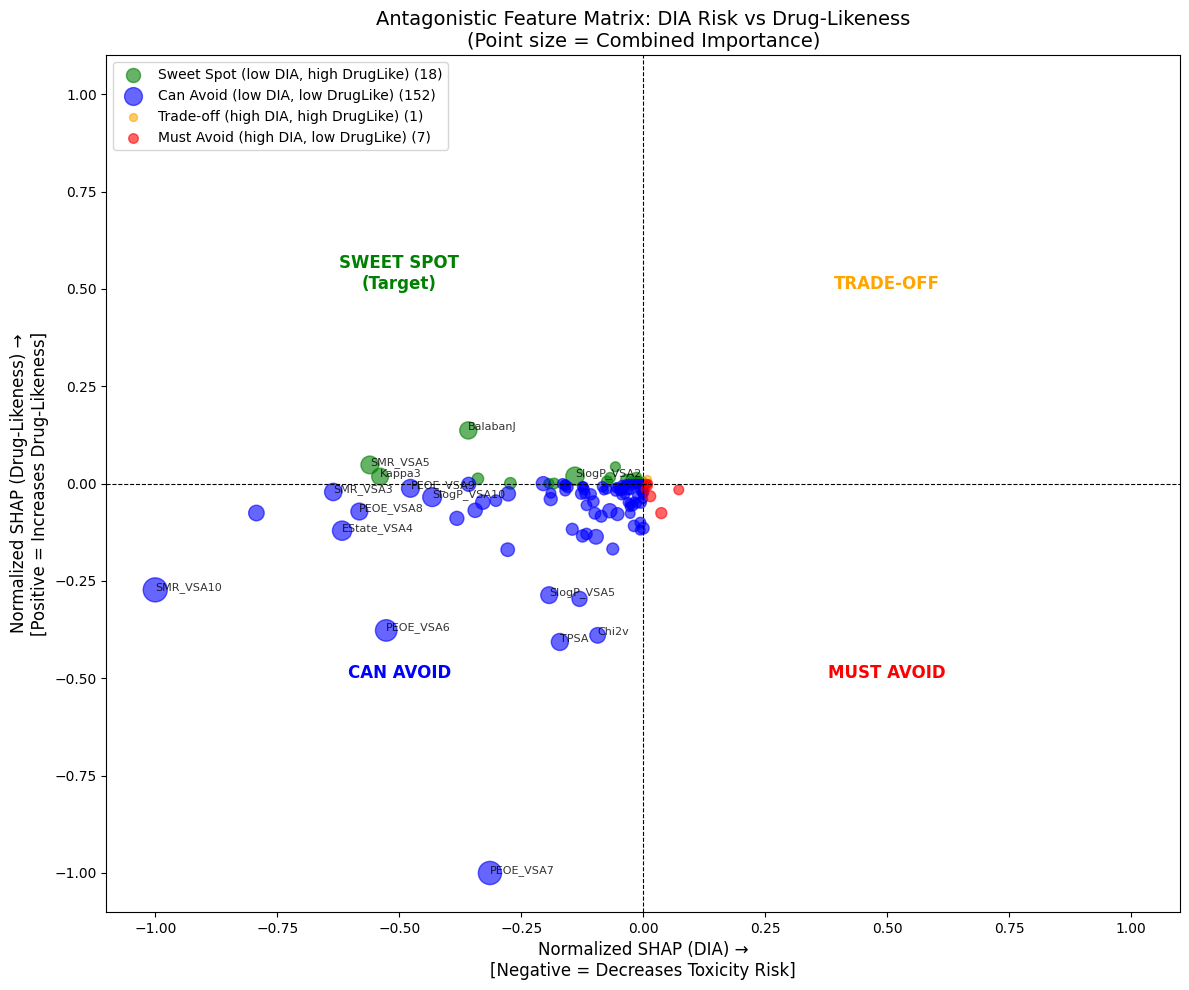

In [ ]:
# ANTAGONISTIC FEATURES

fig, ax = plt.subplots(figsize=(12, 10))

colors = {
    'Sweet Spot (low DIA, high DrugLike)': 'green',
    'Can Avoid (low DIA, low DrugLike)': 'blue',
    'Trade-off (high DIA, high DrugLike)': 'orange',
    'Must Avoid (high DIA, low DrugLike)': 'red'
}

# scale point sizes by Combined_Importance, since positions of points are quite misleading
min_size, max_size = 30, 300
importance_normalized = (antagonistic_df['Combined_Importance'] - antagonistic_df['Combined_Importance'].min()) / (antagonistic_df['Combined_Importance'].max() - antagonistic_df['Combined_Importance'].min())
antagonistic_df['Point_Size'] = min_size + importance_normalized * (max_size - min_size)

for quadrant, color in colors.items():
    subset = antagonistic_df[antagonistic_df['Quadrant'] == quadrant]
    ax.scatter(subset['SHAP_DIA'], subset['SHAP_DrugLike'],
               c=color, label=f"{quadrant} ({len(subset)})",
               alpha=0.6, s=subset['Point_Size'])  # ← Size varies by importance

ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)

# label most important features
top_features = antagonistic_df.nlargest(15, 'Combined_Importance')
for _, row in top_features.iterrows():
    ax.annotate(row['Feature'],
                (row['SHAP_DIA'], row['SHAP_DrugLike']),
                fontsize=8, alpha=0.8)

ax.set_xlabel('Normalized SHAP (DIA) →\n[Negative = Decreases Toxicity Risk]', fontsize=12)
ax.set_ylabel('Normalized SHAP (Drug-Likeness) →\n[Positive = Increases Drug-Likeness]', fontsize=12)
ax.set_title('Antagonistic Feature Matrix: DIA Risk vs Drug-Likeness\n(Point size = Combined Importance)', fontsize=14)
ax.legend(loc='upper left')

ax.text(-0.5, 0.5, 'SWEET SPOT\n(Target)', fontsize=12, ha='center', color='green', weight='bold')
ax.text(0.5, 0.5, 'TRADE-OFF', fontsize=12, ha='center', color='orange', weight='bold')
ax.text(-0.5, -0.5, 'CAN AVOID', fontsize=12, ha='center', color='blue', weight='bold')
ax.text(0.5, -0.5, 'MUST AVOID', fontsize=12, ha='center', color='red', weight='bold')

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

plt.tight_layout()
plt.show()

###For cell above
Interpretation: SlogP_VSA2, SMR_VSA5, Kappa3, Balabanj are most crucial features in sweet spot.<br>
Hard to compare by eye, so another visualization will be created to show importance more clearly.

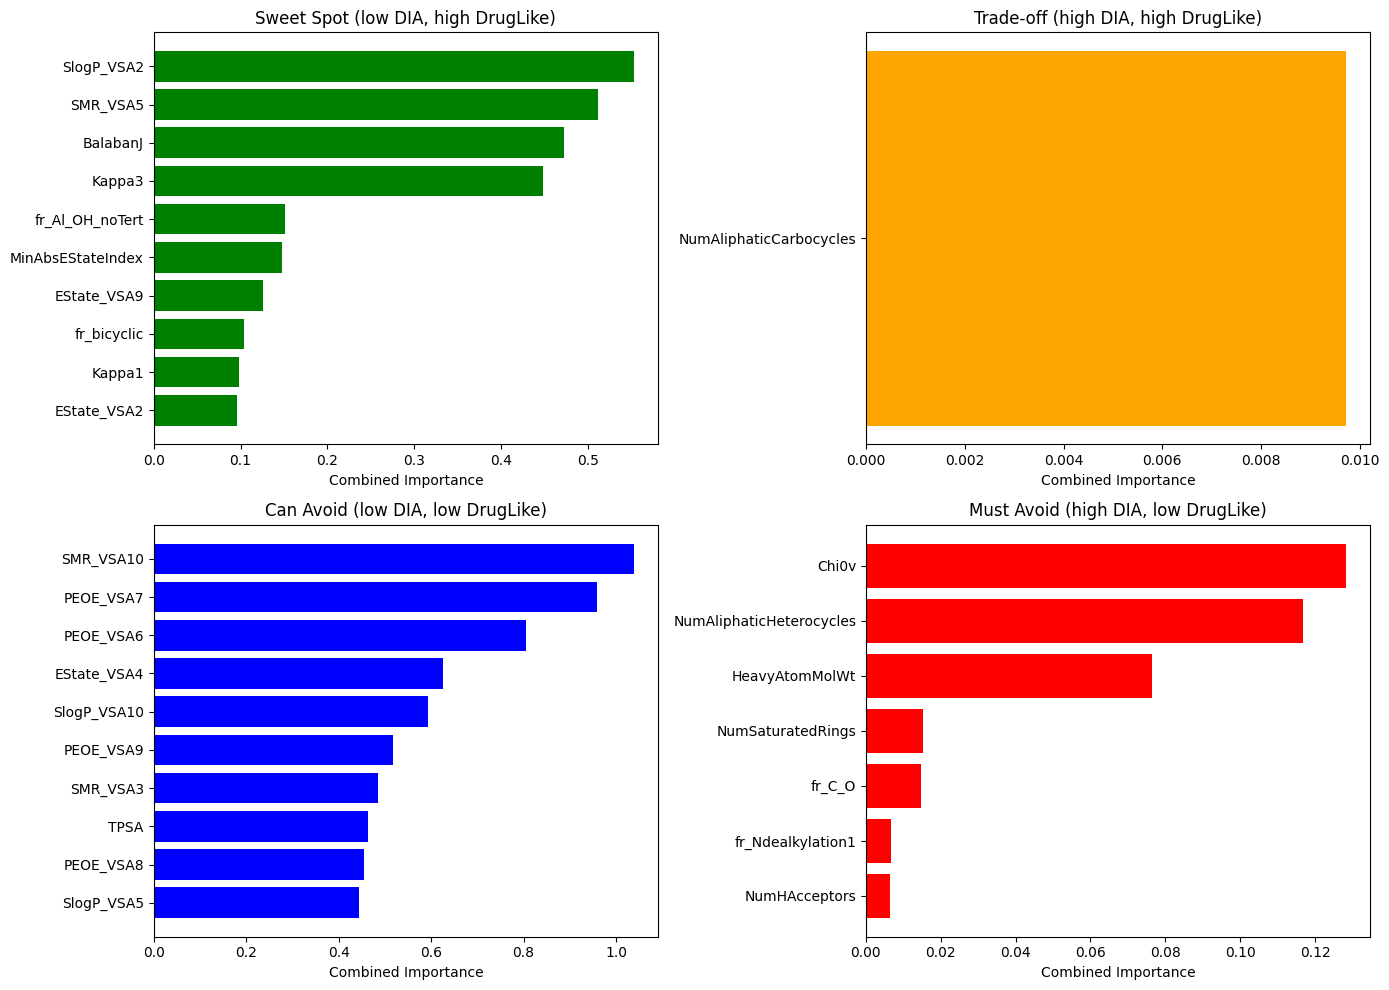

In [ ]:
# top 10 features by quadrant (bar) - alternative visualization to above

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

quadrant_order = [
    'Sweet Spot (low DIA, high DrugLike)',
    'Trade-off (high DIA, high DrugLike)',
    'Can Avoid (low DIA, low DrugLike)',
    'Must Avoid (high DIA, low DrugLike)'
]

colors = {
    'Sweet Spot (low DIA, high DrugLike)': 'green',
    'Can Avoid (low DIA, low DrugLike)': 'blue',
    'Trade-off (high DIA, high DrugLike)': 'orange',
    'Must Avoid (high DIA, low DrugLike)': 'red'
}

for ax, quadrant in zip(axes.flatten(), quadrant_order):
    subset = antagonistic_df[antagonistic_df['Quadrant'] == quadrant].head(10)
    if len(subset) > 0:
        ax.barh(subset['Feature'], subset['Combined_Importance'], color=colors[quadrant])
        ax.set_xlabel('Combined Importance')
        ax.set_title(quadrant)
        ax.invert_yaxis()
    else:
        ax.text(0.5, 0.5, 'No features', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(quadrant)

plt.tight_layout()
plt.show()

## 9. Comparison: SHAP vs Native Feature Importance

Check if SHAP prioritizes similar features to base native XGBoost model.

In [ ]:
print("="*70)
print("VALIDATION: Native XGBoost vs SHAP Importance")
print("="*70)

from scipy.stats import spearmanr

# ============ MODEL 1 (DIA) ============
print("\n" + "-"*50)
print("MODEL 1 (DIA)")
print("-"*50)

native_importance_dia = pd.Series(
    model_dia_optimized.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

shap_importance_dia = mean_abs_shap_dia.sort_values(ascending=False)

print("\nTop 10 by Native Importance:")
print(native_importance_dia.head(10))

print("\nTop 10 by SHAP Importance:")
print(shap_importance_dia.head(10))

common_features_dia = list(set(native_importance_dia.index) & set(shap_importance_dia.index))
corr_dia, pval_dia = spearmanr(
    native_importance_dia[common_features_dia].rank(ascending=False),
    shap_importance_dia[common_features_dia].rank(ascending=False)
)
print(f"\nSpearman correlation: {corr_dia:.4f} (p={pval_dia:.4e})")

# ============ MODEL 2 (Drug-Likeness) ============
print("\n" + "-"*50)
print("MODEL 2 (Drug-Likeness)")
print("-"*50)

native_importance_dl = pd.Series(
    model_druglike_optimized.feature_importances_,
    index=X_train_m2.columns
).sort_values(ascending=False)

shap_importance_dl = mean_abs_shap_druglike.sort_values(ascending=False)

print("\nTop 10 by Native Importance:")
print(native_importance_dl.head(10))

print("\nTop 10 by SHAP Importance:")
print(shap_importance_dl.head(10))

common_features_dl = list(set(native_importance_dl.index) & set(shap_importance_dl.index))
corr_dl, pval_dl = spearmanr(
    native_importance_dl[common_features_dl].rank(ascending=False),
    shap_importance_dl[common_features_dl].rank(ascending=False)
)
print(f"\nSpearman correlation: {corr_dl:.4f} (p={pval_dl:.4e})")

print(f"Model 1 (DIA):         Spearman r = {corr_dia:.4f}")
print(f"Model 2 (Drug-Like):   Spearman r = {corr_dl:.4f}")

VALIDATION: Native XGBoost vs SHAP Importance

--------------------------------------------------
MODEL 1 (DIA)
--------------------------------------------------

Top 10 by Native Importance:
fr_pyridine                0.058060
NumAromaticCarbocycles     0.046129
fr_methoxy                 0.041335
NumSaturatedCarbocycles    0.031569
RingCount                  0.028021
NumAromaticRings           0.027899
fr_Ar_COO                  0.023641
PEOE_VSA2                  0.022302
fr_NH1                     0.020560
fr_Al_OH_noTert            0.019092
dtype: float32

Top 10 by SHAP Importance:
SlogP_VSA10    0.551234
SMR_VSA10      0.510893
PEOE_VSA6      0.440392
SMR_VSA3       0.392979
SMR_VSA5       0.367941
EState_VSA4    0.363127
PEOE_VSA8      0.356405
PEOE_VSA9      0.334819
Kappa3         0.288600
fr_NH2         0.277725
Name: Abs_SHAP_DIA, dtype: float32

Spearman correlation: 0.7299 (p=4.6326e-31)

--------------------------------------------------
MODEL 2 (Drug-Likeness)
--------

## 10. Summary and Conclusions

In [ ]:
print("\n" + "="*70)
print("DuaSHAP FRAMEWORK - FINAL SUMMARY")
print("="*70)

print("\nMODEL PERFORMANCE:")
print(f"   Model 1 (DIA Toxicity):    AUC = {roc_auc_score(y_test_dia, y_prob_dia):.4f}")
print(f"   Model 2 (Drug-Likeness):   AUC = {roc_auc_score(y_test_druglike, y_prob_druglike):.4f}")

print("\nQUADRANT DISTRIBUTION:")
for quadrant in quadrant_order:
    count = len(antagonistic_df[antagonistic_df['Quadrant'] == quadrant])
    print(f"   {quadrant}: {count} features")

print("\nTOP 5 SWEET SPOT FEATURES:")
if len(sweet_spot) >= 5:
    for i, (_, row) in enumerate(sweet_spot.head(5).iterrows(), 1):
        print(f"   {i}. {row['Feature']}")
        print(f"      SHAP_DIA: {row['SHAP_DIA']:.3f} (↓ toxicity)")
        print(f"      SHAP_DrugLike: {row['SHAP_DrugLike']:.3f} (↑ drug-likeness)")
elif len(sweet_spot) > 0:
    for i, (_, row) in enumerate(sweet_spot.iterrows(), 1):
        print(f"   {i}. {row['Feature']}")
else:
    print("   No Sweet Spot features found.")


DuaSHAP FRAMEWORK - FINAL SUMMARY

MODEL PERFORMANCE:
   Model 1 (DIA Toxicity):    AUC = 0.8733
   Model 2 (Drug-Likeness):   AUC = 0.9224

QUADRANT DISTRIBUTION:
   Sweet Spot (low DIA, high DrugLike): 18 features
   Trade-off (high DIA, high DrugLike): 1 features
   Can Avoid (low DIA, low DrugLike): 152 features
   Must Avoid (high DIA, low DrugLike): 7 features

TOP 5 SWEET SPOT FEATURES:
   1. SlogP_VSA2
      SHAP_DIA: -0.140 (↓ toxicity)
      SHAP_DrugLike: 0.019 (↑ drug-likeness)
   2. SMR_VSA5
      SHAP_DIA: -0.560 (↓ toxicity)
      SHAP_DrugLike: 0.048 (↑ drug-likeness)
   3. BalabanJ
      SHAP_DIA: -0.358 (↓ toxicity)
      SHAP_DrugLike: 0.137 (↑ drug-likeness)
   4. Kappa3
      SHAP_DIA: -0.539 (↓ toxicity)
      SHAP_DrugLike: 0.018 (↑ drug-likeness)
   5. fr_Al_OH_noTert
      SHAP_DIA: -0.272 (↓ toxicity)
      SHAP_DrugLike: 0.001 (↑ drug-likeness)


# Miscellaneous


MULTI-MODEL COMPARISON

Training Logistic Regression...
  CV AUC: 0.7126 (+/- 0.1186)
  Test AUC: 0.7307

Training Random Forest...
  CV AUC: 0.7919 (+/- 0.0239)
  Test AUC: 0.8604

Training XGBoost...
  CV AUC: 0.8337 (+/- 0.0433)
  Test AUC: 0.8733

Training Gradient Boosting...
  CV AUC: 0.8270 (+/- 0.0326)
  Test AUC: 0.8559

MODEL COMPARISON SUMMARY (DIA Prediction)
              Model  CV_AUC_Mean  CV_AUC_Std  Test_AUC  Training_Time
            XGBoost     0.833709    0.021658  0.873333       8.545205
      Random Forest     0.791864    0.011962  0.860370       3.535431
  Gradient Boosting     0.827007    0.016299  0.855926      14.525017
Logistic Regression     0.712638    0.059287  0.730741       0.675959


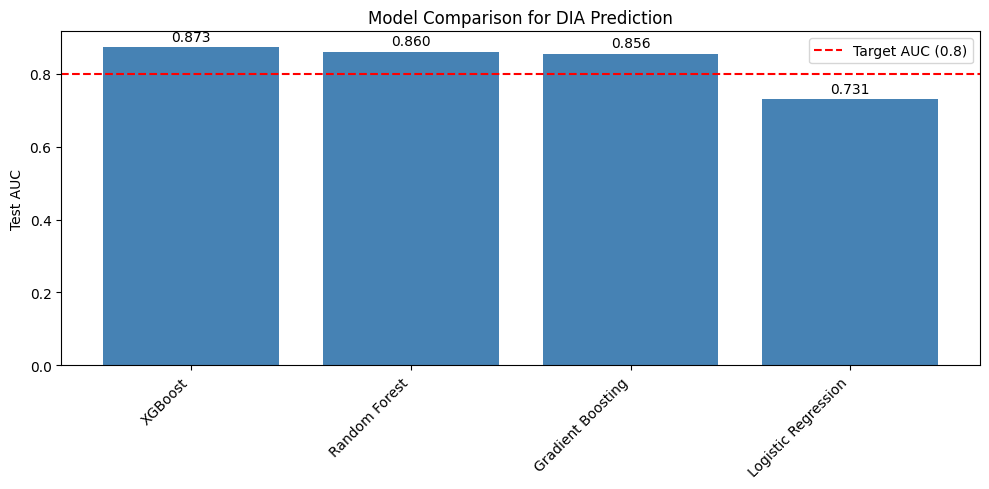

In [ ]:
# comparing different models before starting on project (shouldn't be run now that base project is complete)

# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.svm import SVC
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
# import time

# print("\n" + "="*60)
# print("MULTI-MODEL COMPARISON")
# print("="*60)

# # Define models to compare
# models = {
#     'Logistic Regression': Pipeline([
#         ('scaler', StandardScaler()),
#         ('clf', LogisticRegression(max_iter=1000, random_state=42))
#     ]),
#     'Random Forest': RandomForestClassifier(
#         n_estimators=100,
#         max_depth=5,
#         random_state=42,
#         class_weight='balanced'
#     ),
#     'XGBoost': XGBClassifier(
#         n_estimators=100,
#         max_depth=5,
#         learning_rate=0.1,
#         scale_pos_weight=scale_pos_weight,
#         random_state=42,
#         use_label_encoder=False,
#         eval_metric='logloss'
#     ),
#     'Gradient Boosting': GradientBoostingClassifier(
#         n_estimators=100,
#         max_depth=5,
#         random_state=42
#     )
# }

# # Evaluate each model
# results = []

# for name, model in models.items():
#     print(f"\nTraining {name}...")
#     start_time = time.time()

#     # Cross-validation
#     cv_scores = cross_val_score(model, X_train, y_train_dia, cv=5, scoring='roc_auc')

#     # Fit and predict
#     model.fit(X_train, y_train_dia)

#     if hasattr(model, 'predict_proba'):
#         y_prob = model.predict_proba(X_test)[:, 1]
#     else:
#         y_prob = model.decision_function(X_test)

#     test_auc = roc_auc_score(y_test_dia, y_prob)
#     train_time = time.time() - start_time

#     results.append({
#         'Model': name,
#         'CV_AUC_Mean': cv_scores.mean(),
#         'CV_AUC_Std': cv_scores.std(),
#         'Test_AUC': test_auc,
#         'Training_Time': train_time
#     })

#     print(f"  CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
#     print(f"  Test AUC: {test_auc:.4f}")

# # Create comparison table
# comparison_df = pd.DataFrame(results)
# comparison_df = comparison_df.sort_values('Test_AUC', ascending=False)

# print("\n" + "="*60)
# print("MODEL COMPARISON SUMMARY (DIA Prediction)")
# print("="*60)
# print(comparison_df.to_string(index=False))

# # Visualize
# fig, ax = plt.subplots(figsize=(10, 5))
# x = range(len(comparison_df))
# bars = ax.bar(x, comparison_df['Test_AUC'], color=['steelblue' for m in comparison_df['Model']])
# ax.set_xticks(x)
# ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
# ax.set_ylabel('Test AUC')
# ax.set_title('Model Comparison for DIA Prediction')
# ax.axhline(y=0.8, color='red', linestyle='--', label='Target AUC (0.8)')
# ax.legend()

# # Add value labels on bars
# for bar, val in zip(bars, comparison_df['Test_AUC']):
#     ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
#             f'{val:.3f}', ha='center', va='bottom', fontsize=10)

# plt.tight_layout()
# plt.show()

In [ ]:
print("\n" + "="*60)
print("Sweet Spot Stability Across Random Seeds")
print("="*60)

sweet_spot_counts = {}
n_runs = 5

for seed in range(42, 42 + n_runs):
    # train DIA model with different seed
    model_temp_dia = XGBClassifier(
        n_estimators=100, max_depth=5, learning_rate=0.1,
        scale_pos_weight=scale_pos_weight,
        random_state=seed, use_label_encoder=False, eval_metric='logloss'
    )
    model_temp_dia.fit(X_train, y_train_dia)

    # train DL model with different seed
    model_temp_dl = XGBClassifier(
        n_estimators=100, max_depth=5, learning_rate=0.1,
        scale_pos_weight=scale_pos_weight_dl,
        random_state=seed, use_label_encoder=False, eval_metric='logloss'
    )
    model_temp_dl.fit(X_train_m2, y_train_druglike)

    # calc SHAP for both models
    explainer_dia = shap.TreeExplainer(model_temp_dia)
    shap_dia = explainer_dia.shap_values(X_train)
    mean_shap_dia = pd.Series(shap_dia.mean(axis=0), index=X_train.columns)
    norm_shap_dia_temp = mean_shap_dia / np.abs(mean_shap_dia).max()

    explainer_dl = shap.TreeExplainer(model_temp_dl)
    shap_dl = explainer_dl.shap_values(X_train_m2)
    mean_shap_dl = pd.Series(shap_dl.mean(axis=0), index=X_train_m2.columns)
    norm_shap_dl_temp = mean_shap_dl / np.abs(mean_shap_dl).max()

    # find Sweet Spot features
    common_features = set(norm_shap_dia_temp.index) & set(norm_shap_dl_temp.index)
    for feature in common_features:
        if norm_shap_dia_temp[feature] < 0 and norm_shap_dl_temp[feature] > 0:
            if feature in sweet_spot_counts:
                sweet_spot_counts[feature] += 1
            else:
                sweet_spot_counts[feature] = 1

stable_sweet_spot = {f: count for f, count in sweet_spot_counts.items() if count >= n_runs - 1}

print(f"\nFeatures in Sweet Spot ({n_runs-1}+ out of {n_runs} runs):")
if stable_sweet_spot:
    for f, count in sorted(stable_sweet_spot.items(), key=lambda x: -x[1]):
        in_original = "✓" if f in sweet_spot['Feature'].values else "✗"
        print(f"  {in_original} {f}: {count}/{n_runs} runs")
else:
    print("  No features consistently in Sweet Spot across all seeds")

print(f"\nOriginal Sweet Spot features: {len(sweet_spot)}")
print(f"Stable Sweet Spot features: {len(stable_sweet_spot)}")
print(f"\nSweet Spot is {'STABLE' if len(stable_sweet_spot) >= 3 else 'UNSTABLE'} across random seeds")


Sweet Spot Stability Across Random Seeds

Features in Sweet Spot (4+ out of 5 runs):
  ✓ SMR_VSA5: 5/5 runs
  ✓ NumHeteroatoms: 5/5 runs
  ✓ EState_VSA9: 5/5 runs
  ✓ SMR_VSA1: 5/5 runs
  ✓ Kappa1: 5/5 runs
  ✓ fr_NH0: 5/5 runs
  ✓ fr_Ar_OH: 5/5 runs
  ✓ Chi0: 5/5 runs
  ✓ MolMR: 5/5 runs
  ✓ fr_Al_OH_noTert: 5/5 runs
  ✓ BalabanJ: 5/5 runs
  ✓ Kappa3: 5/5 runs
  ✓ fr_C_O_noCOO: 5/5 runs

Original Sweet Spot features: 18
Stable Sweet Spot features: 13

Sweet Spot is STABLE across random seeds


###For cell above
Decently stable for sweet spot features, SMR_VSA5, Kappa3, BalabanJ can be seen as reliable.